# Candidate List Solution

[Ogle et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...817..109O/abstract) mined the NASA/IPAC Extragalactic Database (NED) to identify a new type of galaxy: Superluminous Spiral Galaxies.

Table 1 lists the positions of these Super Spirals. Based on those positions, let's create multiwavelength cutouts for each super spiral to see what is unique about this new class of objects.

## 1. Import the Python modules we'll be using

In [1]:
# Suppress unimportant warnings.
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")
warnings.filterwarnings('ignore', '.*RADECSYS=*', append=True)

import matplotlib.pyplot as plt
import numpy as np

# For downloading files
from astropy.utils.data import download_file

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
import astropy.visualization as vis
from astropy.wcs import WCS
from astroquery.ipac.ned import Ned

import pyvo as vo

The next cell prepares the notebook to display our visualizations.

In [2]:
%matplotlib inline

## 2. Search NED for objects in this paper

Insert a Code Cell below by clicking on the "Insert" Menu and choosing "Insert Cell Below". Then consult QuickReference.md to figure out how to use astroquery to search NED for all objects in a paper, based on the refcode of the paper. Inspect the resulting astropy table.

In [3]:
objects_in_paper = Ned.query_refcode('2016ApJ...817..109O')
objects_in_paper.show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
0,1,WISEA J001550.14-100242.3,3.95892,-10.04511,G,52766.0,0.17601,SLS,17.5g,--,15,0,63,8,9,10,0
1,2,WISEA J003807.80-010936.7,9.53254,-1.16022,G,62442.0,0.208284,SLS,18.0g,--,16,0,72,12,11,10,0
2,3,WISEA J040422.92-054134.8,61.09553,-5.693,G,75113.0,0.250549,SLS,18.6g,--,7,0,61,10,9,8,0
3,4,WISEA J073806.16+282359.6,114.52568,28.3999,G,69225.0,0.230909,SLS,18.0g,--,10,0,66,7,7,10,0
4,5,2MASX J07550424+1353261,118.76779,13.89069,G,66746.0,0.22264,SLS,18.5g,--,10,0,38,7,9,6,0
5,6,WISEA J082655.11+181147.7,126.72963,18.19659,G,79580.0,0.265449,SLS,18.4g,--,8,0,46,7,8,6,0
6,7,2MASX J08542169+0449308,133.59031,4.82505,G,47005.0,0.156793,SLS,16.7g,--,18,0,58,8,9,10,0
7,8,WHL J090944.8+222607,137.43669,22.43538,GClstr,88683.0,0.295813,PUN,,--,7,0,0,4,6,0,0
8,9,2MASX J09094480+2226078,137.43671,22.43535,G,85557.0,0.285388,SLS,19.0g,--,9,0,30,5,8,6,0


## 3. Filter the NED results

The results from NED will include galaxies, but also other kinds of objects (e.g. galaxy clusters, galaxy groups). Print the 'Type' column to see the full range of classifications and filter the results so that we only keep the galaxies in the list.

In [4]:
objects_in_paper['Type']

G
G
G
G
G
G
G
GClstr
G
G
GClstr


In [5]:
# Keep only the galaxies from the list
galaxies = objects_in_paper[np.array(objects_in_paper['Type']) == 'G']

galaxies.show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


idx,No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
0,1,WISEA J001550.14-100242.3,3.95892,-10.04511,G,52766.0,0.17601,SLS,17.5g,--,15,0,63,8,9,10,0
1,2,WISEA J003807.80-010936.7,9.53254,-1.16022,G,62442.0,0.208284,SLS,18.0g,--,16,0,72,12,11,10,0
2,3,WISEA J040422.92-054134.8,61.09553,-5.693,G,75113.0,0.250549,SLS,18.6g,--,7,0,61,10,9,8,0
3,4,WISEA J073806.16+282359.6,114.52568,28.3999,G,69225.0,0.230909,SLS,18.0g,--,10,0,66,7,7,10,0
4,5,2MASX J07550424+1353261,118.76779,13.89069,G,66746.0,0.22264,SLS,18.5g,--,10,0,38,7,9,6,0
5,6,WISEA J082655.11+181147.7,126.72963,18.19659,G,79580.0,0.265449,SLS,18.4g,--,8,0,46,7,8,6,0
6,7,2MASX J08542169+0449308,133.59031,4.82505,G,47005.0,0.156793,SLS,16.7g,--,18,0,58,8,9,10,0
7,9,2MASX J09094480+2226078,137.43671,22.43535,G,85557.0,0.285388,SLS,19.0g,--,9,0,30,5,8,6,0
8,10,2MASX J09260805+2405242,141.53355,24.09009,G,66672.0,0.222393,SLS,17.8g,--,16,0,32,7,13,6,0


## 4. Search the NAVO Registry for image resources

The paper selected super spirals using WISE, SDSS, and GALEX images. Search the NAVO registry for image resources, using the 'servicetype' search parameter. How many image resources are currently available?

In [6]:
image_services = vo.regsearch(servicetype='sia')

print(f'{len(image_services)} result(s) found.')

image_services.to_table()['ivoid', 'short_name', 'res_title']

321 result(s) found.


ivoid,short_name,res_title
object,object,object
ivo://3crsnapshots/sia,3CRSnap.sia,3CRSnapshots Simple Image Access Service
ivo://archive.stsci.edu/borg,BoRG,Brightest of Reionizing Galaxies (BoRG)
ivo://archive.stsci.edu/ghosts,GHOSTS,"Galaxy Halos, Outer disks, Substructure, Thick disks and Star clusters (GHOSTS)"
ivo://archive.stsci.edu/sia/galex,GALEX,Galaxy Evolution Explorer (GALEX)
ivo://archive.stsci.edu/siap/hla,HLA,Hubble Legacy Archive
ivo://arvo/siap,ArVO SIAP,Armenian Virtual Observatory SIAP
ivo://astron.nl/apertif_dr_bootes/q/cutout,DR Bootes,Apertif DR Bootes - Mosaic
ivo://astron.nl/hetdex/lotss-dr1-img/cutout,LoTSS-DR1 Cutout,LoTSS-DR1 Image Cutout Service
ivo://astron.nl/hetdex/lotss-dr1-img/imgs,LoTSS-DR1 images,LoTSS-DR1 Image Archive


## 5. Search the NAVO Registry for image resources that will allow you to search for AllWISE images

There are hundreds of image resources...too many to quickly read through. Try adding the 'keywords' search parameter to your registry search, and find the image resource you would need to search the AllWISE images. Remember from the Known Issues that 'keywords' must be a list.

In [7]:
allwise_image_services = vo.regsearch(servicetype='sia', keywords=['allwise'])

print(f'{len(allwise_image_services)} result(s) found.')

allwise_image_services.to_table()['ivoid', 'short_name', 'res_title']

1 result(s) found.


ivoid,short_name,res_title
object,object,object
ivo://irsa.ipac/wise/images/allwise/l3a,AllWISE L3a,AllWISE Atlas (L3a) Coadd Images


## 6. Choose the AllWISE image service that you are interested in

In [8]:
allwise_image_service = allwise_image_services[0]
allwise_image_service.service

SIAService(baseurl : 'https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?', description : 'None')

## 7. Choose one of the galaxies in the NED list

In [9]:
ra = galaxies['RA'][0]
dec = galaxies['DEC'][0]
pos = SkyCoord(ra, dec, unit = 'deg')

In [10]:
ra,dec

(np.float64(3.95892), np.float64(-10.04511))

## 8. Search for a list of AllWISE images that cover this galaxy

How many images are returned? Which are you most interested in?

In [11]:
allwise_image_table = allwise_image_service.search(pos=pos, size=0)
allwise_image_table

<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W2 Coadd 0046m107_ac51 ... 0046m107_ac51
W1 Coadd 0046m107_ac51 ... 0046m107_ac51
W3 Coadd 0046m107_ac51 ... 0046m107_ac51
W4 Coadd 0046m107_ac51 ... 0046m107_ac51

## 9. Use the .to_table() method to view the results as an Astropy table

In [12]:
allwise_images = allwise_image_table.to_table()
allwise_images

sia_title,sia_url,cloud_access,sia_naxes,sia_fmt,sia_ra,sia_dec,sia_naxis,sia_crpix,sia_crval,sia_proj,sia_scale,sia_cd,sia_bp_id,sia_bp_ref,sia_bp_hi,sia_bp_lo,sia_bp_unit,magzp,magzpunc,unc_url,cov_url,coadd_id
,,,,,deg,deg,,pix,deg,,deg / pix,deg / pix,,,,,,,,,,
object,object,object,int32,object,float64,float64,int32[2],float64[2],float64[2],object,float64[2],float64[4],object,float64,float64,float64,object,float64,float64,object,object,object
W2 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w2-int-3.fits,"{""aws"": {""bucket_name"": ""nasa-irsa-wise"", ""key"":""wise/allwise/images/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w2-int-3.fits"", ""region"": ""us-west-2""}}",2,image/fits,4.61538,-10.601111,4095 .. 4095,2048.0 .. 2048.0,4.61538 .. -10.601111,SIN,-0.0003819444391411 .. 0.0003819444391411,-0.0003819444391411 .. 0.0003819444391411,W2,4.6e-06,5.19e-06,4.02e-06,m,19.5,0.007,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w2-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w2-cov-3.fits.gz,0046m107_ac51
W1 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-int-3.fits,"{""aws"": {""bucket_name"": ""nasa-irsa-wise"", ""key"":""wise/allwise/images/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-int-3.fits"", ""region"": ""us-west-2""}}",2,image/fits,4.61538,-10.601111,4095 .. 4095,2048.0 .. 2048.0,4.61538 .. -10.601111,SIN,-0.0003819444391411 .. 0.0003819444391411,-0.0003819444391411 .. 0.0003819444391411,W1,3.35e-06,3.78e-06,3.13e-06,m,20.5,0.006,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w1-cov-3.fits.gz,0046m107_ac51
W3 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w3-int-3.fits,"{""aws"": {""bucket_name"": ""nasa-irsa-wise"", ""key"":""wise/allwise/images/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w3-int-3.fits"", ""region"": ""us-west-2""}}",2,image/fits,4.61538,-10.601111,4095 .. 4095,2048.0 .. 2048.0,4.61538 .. -10.601111,SIN,-0.0003819444391411 .. 0.0003819444391411,-0.0003819444391411 .. 0.0003819444391411,W3,1.156e-05,1.627e-05,7.6e-06,m,18.0,0.012,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w3-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w3-cov-3.fits.gz,0046m107_ac51
W4 Coadd 0046m107_ac51,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w4-int-3.fits,"{""aws"": {""bucket_name"": ""nasa-irsa-wise"", ""key"":""wise/allwise/images/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w4-int-3.fits"", ""region"": ""us-west-2""}}",2,image/fits,4.61538,-10.601111,4095 .. 4095,2048.0 .. 2048.0,4.61538 .. -10.601111,SIN,-0.0003819444391411 .. 0.0003819444391411,-0.0003819444391411 .. 0.0003819444391411,W4,2.209e-05,2.336e-05,1.984e-05,m,13.0,0.012,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w4-unc-3.fits.gz,https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/00/0046/0046m107_ac51/0046m107_ac51-w4-cov-3.fits.gz,0046m107_ac51


## 10. From the result in 8., select the first record for an image taken in WISE band W1 (3.6 micron)

Hints:

* Loop over records and test on the `.bandpass_id` attribute of each record
* Print the `.title` and `.bandpass_id` of the record you find, to verify it is the right one.

In [13]:
for allwise_image_record in allwise_image_table:
    if 'W1' in allwise_image_record.bandpass_id:
        break
print(allwise_image_record.title, allwise_image_record.bandpass_id)

W1 Coadd 0046m107_ac51 W1


## 11. Visualize this AllWISE image

In [14]:
## If you only run this once, you can do it in memory in one line:
##  This fetches the FITS as an astropy.io.fits object in memory
#allwise_w1_image = allwise_image_record.getdataobj()
## But if you might run this notebook repeatedly with limited bandwidth,
##  download it once and cache it.
file_name = download_file(allwise_image_record.getdataurl(), cache=True)
allwise_w1_image = fits.open(file_name)

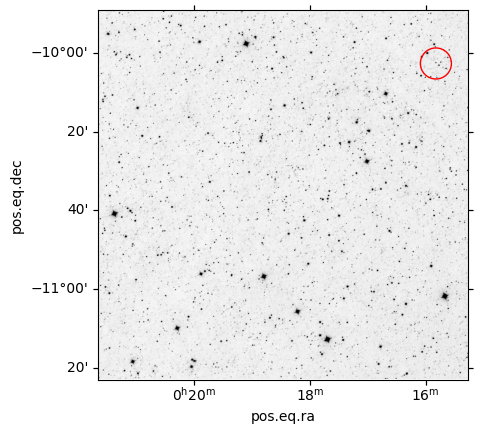

In [15]:
fig = plt.figure()

wcs = WCS(allwise_w1_image[0].header)
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(allwise_w1_image[0].data, cmap='gray_r', origin='lower', vmax = 10)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

## 12. Plot a cutout of the AllWISE image, centered on your position

Try a 60 arcsecond cutout.

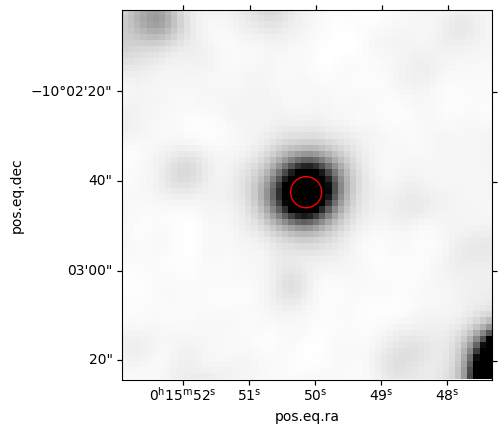

In [16]:
size = 60
cutout = Cutout2D(allwise_w1_image[0].data, pos, (size, size), wcs=wcs)
wcs = cutout.wcs

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(cutout.data, cmap='gray_r', origin='lower', vmax = 10)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

## 13. Try visualizing a cutout of a GALEX image that covers your position

Repeat steps 4, 5, 6, 8 through 12 for GALEX.

In [17]:
galex_image_services = vo.regsearch(keywords=['galex'], servicetype='sia')
print(f'{len(galex_image_services)} result(s) found.')
galex_image_services.to_table()['ivoid', 'short_name', 'res_title']

3 result(s) found.


ivoid,short_name,res_title
object,object,object
ivo://archive.stsci.edu/sia/galex,GALEX,Galaxy Evolution Explorer (GALEX)
ivo://mast.stsci/siap/galex_atlas,GALEX_Atlas,GALEX Atlas of Nearby Galaxies
ivo://nasa.heasarc/skyview/galex,GALEX,Galaxy Explorer All Sky Survey: Near UV


In [18]:
galex_image_service = galex_image_services[0]

In [19]:
galex_image_table = galex_image_service.search(pos=pos, size=0.0, intersect='covers')

In [20]:
for i in range(len(galex_image_table)):
    if (('image/fits' in galex_image_table[i].format) and
        (galex_image_table['energy_bounds_center'][i]==2.35e-07) and
        (galex_image_table[i]['productType'] == 'SCIENCE')):
        break
galex_image_record = galex_image_table[i]
print(galex_image_record.title, galex_image_record.bandpass_id)

AIS_270_0004_sg14-nd-int.fits.gz NUV


In [21]:
## See above regarding two ways to do this:
#galex_nuv_image = fits.open(galex_image_record.getdataurl())
file_name = download_file(galex_image_record.getdataurl(), cache=True)
galex_nuv_image=fits.open(file_name)

In [22]:
image_data = galex_nuv_image[0].data
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 0.0
Max: 8.866534
Mean: 0.0014750387
Stdev: 0.013614772


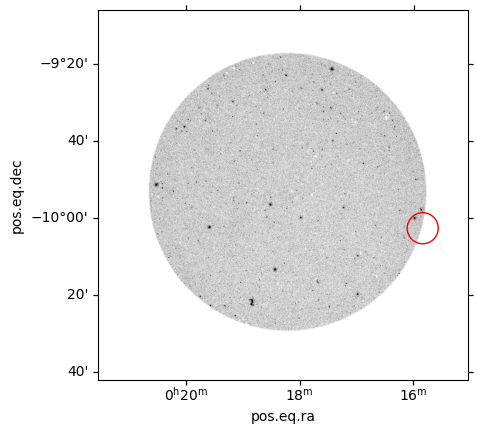

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=WCS(galex_nuv_image[0].header))
ax.imshow(galex_nuv_image[0].data, cmap='gray_r', origin='lower', vmin=0.0, vmax=0.01)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

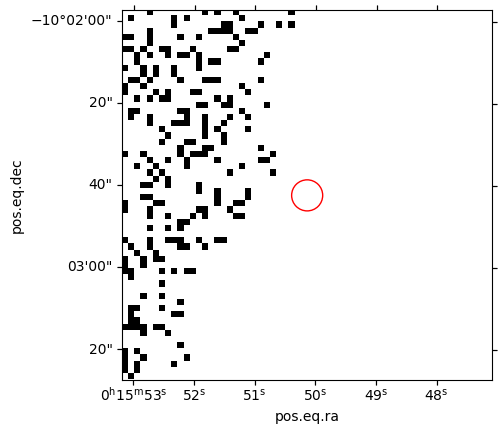

In [24]:
cutout = Cutout2D(galex_nuv_image[0].data, pos, size, wcs=WCS(galex_nuv_image[0].header))

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=cutout.wcs)
ax.imshow(cutout.data, cmap='gray_r', origin='lower', vmin = 0.0, vmax = 0.01)
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

## 14. Try visualizing a cutout of an SDSS image that covers your position

Hints:

* Search the registry using `keywords=['sloan']
* Find the service with a `short_name` of `'SDSS SIAP'`
* After obtaining your search results, select r-band images using the `.title` attribute of the records that are returned, since `.bandpass_id` is not populated.

In [25]:
sdss_image_services = vo.regsearch(keywords=['sloan'], servicetype='sia')
sdss_image_services.to_table()['ivoid', 'short_name', 'res_title', 'source_value']

ivoid,short_name,res_title,source_value
object,object,object,object
ivo://mast.stsci/siap/al218,VLA.AL218,VLA-A Array AL218 Texas Survey Source Snapshots (AL218),
ivo://mast.stsci/siap/vla-first,VLA-FIRST,VLA Faint Images of the Radio Sky at Twenty Centimeters (FIRST),
ivo://nasa.heasarc/skyview/sdss,SDSS,Sloan Digital Sky Survey g-band,
ivo://nasa.heasarc/skyview/sdssdr7,SDSSDR7,Sloan Digital Sky Survey g-band DR7,
ivo://nasa.heasarc/skyview/stripe82vla,Stripe82VLA,VLA Survey of SDSS Stripe 82,
ivo://org.gavo.dc/bgds/q/sia,bgds sia,Bochum Galactic Disk Survey (BGDS) images,2015AN....336..590H
ivo://sdss.jhu/services/siap-images,SDSS SIAP,Sloan Digital Sky Survey Images (Latest Release),
ivo://sdss.jhu/services/siapdr1-images,SDSSDR1,Sloan Digital Sky Survey DR1 - Images,
ivo://sdss.jhu/services/siapdr2-images,SDSSDR2,Sloan Digital Sky Survey DR2 - Images,


In [26]:
#  Use list comprehension to check each service's short_name attribute.
#   Given the above, we know the first match is the right one.
sdss_image_service = [s for s in sdss_image_services if 'SDSS SIAP' in s.short_name ][0]
sdss_image_service.short_name

'SDSS SIAP'

In [27]:
sdss_image_table = sdss_image_service.search(pos=pos, size=0.0)
len(sdss_image_table['Title'])

60

In [28]:
for sdss_rband_record in sdss_image_table:
    if 'Sloan Digital Sky Survey - Filter r' in sdss_rband_record.title:
        break
print(sdss_rband_record.title, sdss_rband_record.bandpass_id)

Sloan Digital Sky Survey - Filter r None


In [29]:
##  See above regarding two ways to do this
# sdss_rband_image = fits.open(sdss_rband_record.getdataurl())
file_name = download_file(sdss_rband_record.getdataurl(), cache=True)
sdss_rband_image=fits.open(file_name)

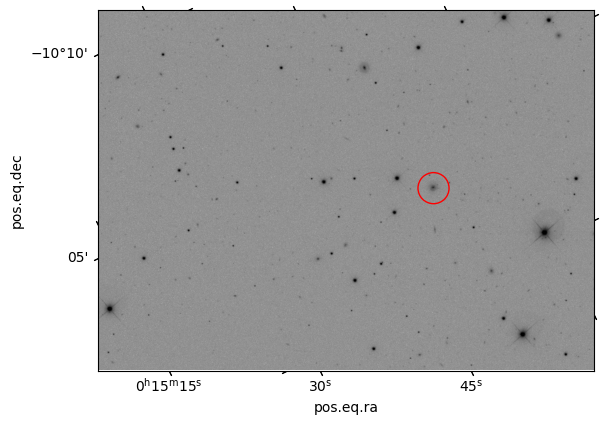

In [30]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=WCS(sdss_rband_image[0].header))

interval = vis.PercentileInterval(99.9)
vmin,vmax = interval.get_limits(sdss_rband_image[0].data)
norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
ax.imshow(sdss_rband_image[0].data, cmap = 'gray_r', norm = norm, origin = 'lower')
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

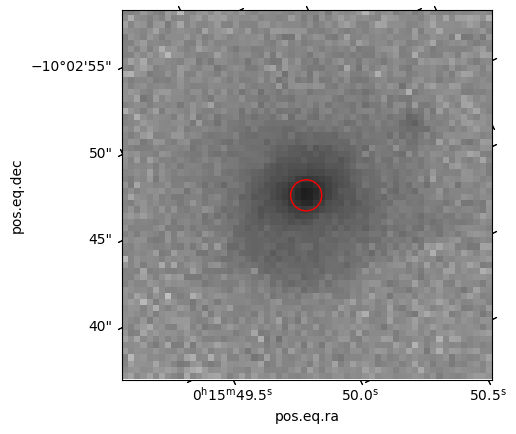

In [31]:
cutout = Cutout2D(sdss_rband_image[0].data, pos, size, wcs=WCS(sdss_rband_image[0].header))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=cutout.wcs)
vmin,vmax = interval.get_limits(sdss_rband_image[0].data)
norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
ax.imshow(cutout.data, cmap = 'gray_r', norm = norm, origin = 'lower')
ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')

## 15. Try looping over all positions and plotting multiwavelength cutouts

Warning: this cell takes a long time to run! We limit it to the first three galaxies only.

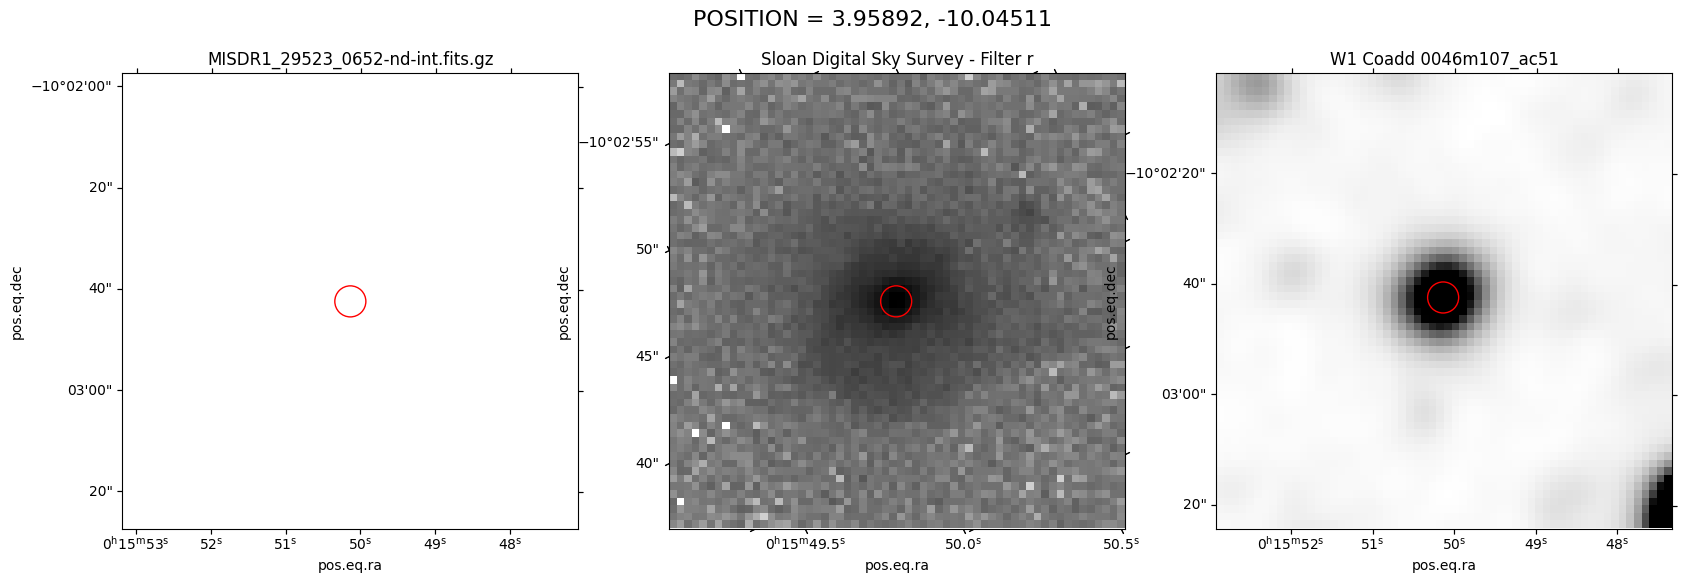

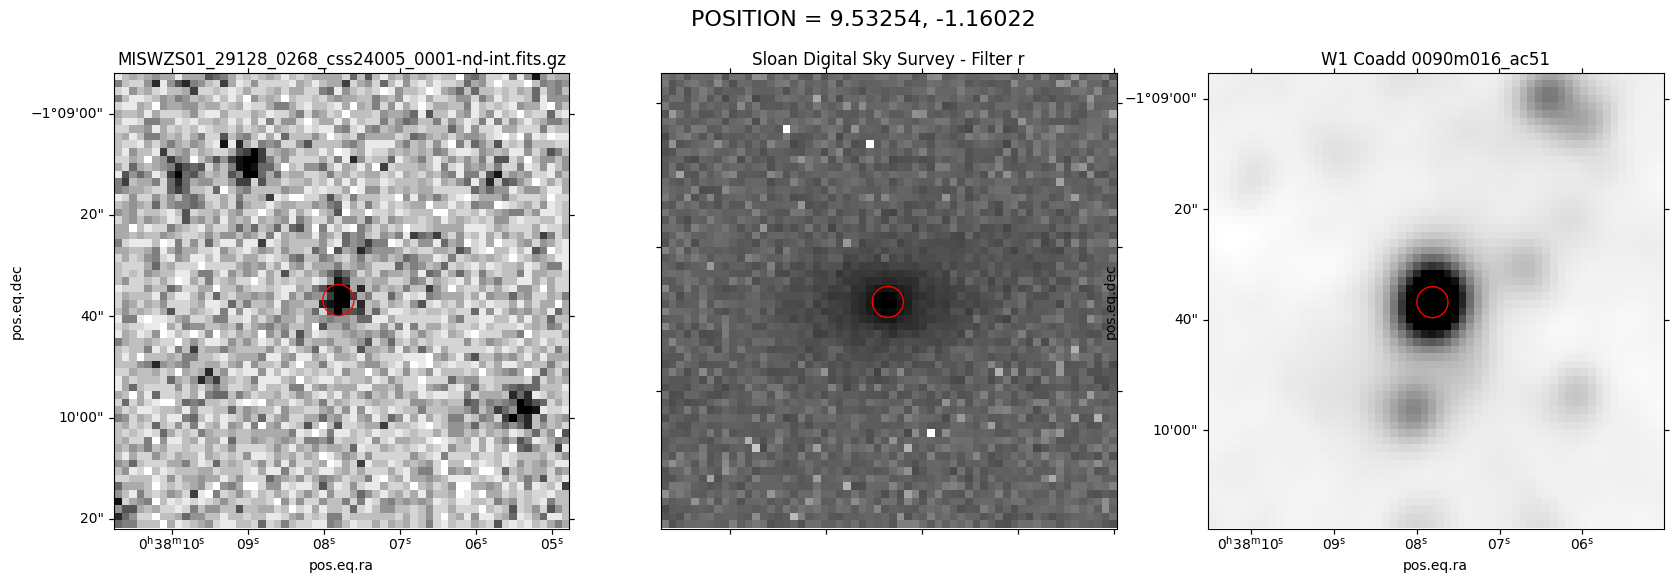

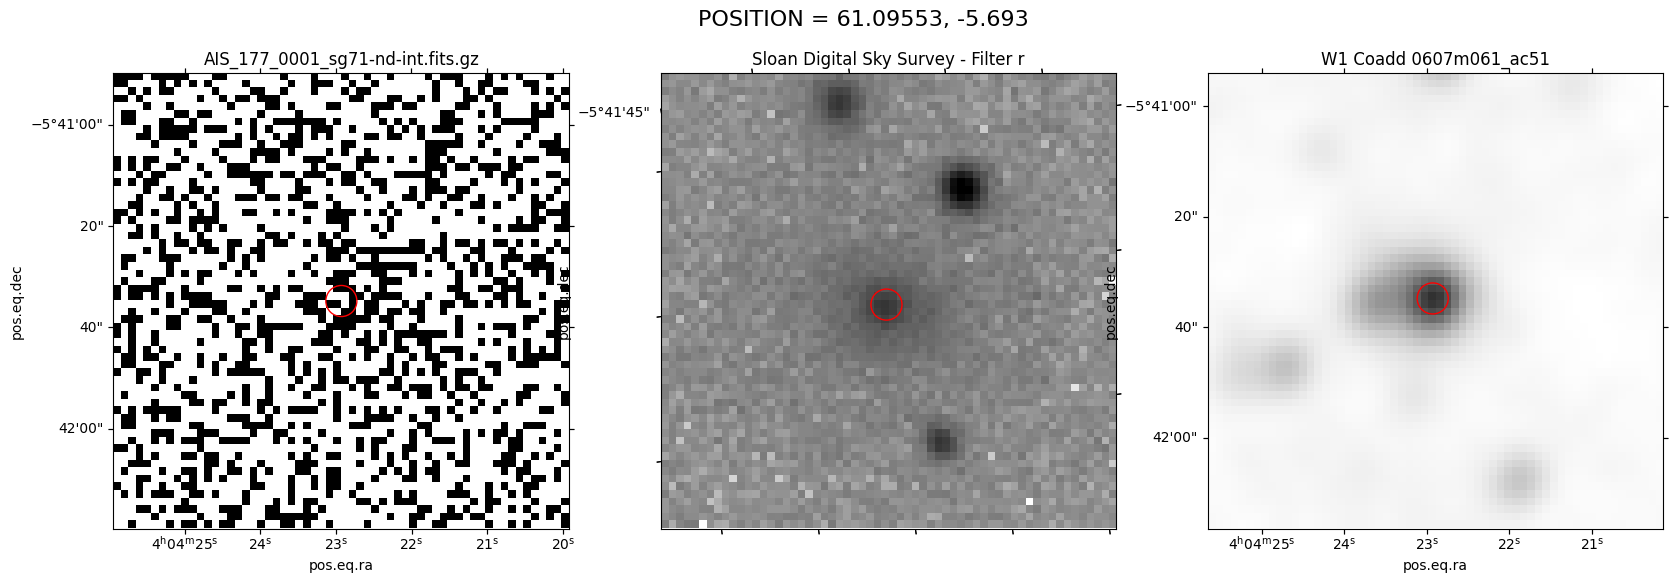

In [32]:
# Pick the first 3 galaxies.
galaxy_subset = galaxies[0:3]

# For each galaxy,
for galaxy in galaxy_subset:

    # Establish the position.
    ra = galaxy['RA']
    dec = galaxy['DEC']
    pos = SkyCoord(ra, dec, unit = 'deg')

    # Set up the plot for this position.
    fig = plt.figure(figsize=(20,6))
    plt.suptitle('POSITION = ' + str(ra) + ', ' + str(dec), fontsize=16)

    # GALEX

    # Find the GALEX images that overlap the position.
    galex_image_table = galex_image_service.search(pos=pos, size=0.25)

    # Find the GALEX All-Sky Image Survey (AIS) Near-UV FITS coadd.
    galex_image_record = None
    for record in galex_image_table:
        if (('image/fits' in record.format) and
            (record['energy_bounds_center'] == 2.35e-07) and
            (record['productType'] == 'SCIENCE')):
            galex_image_record = record
            break

    if galex_image_record is not None:
        # Create a cutout.
        file_name = download_file(galex_image_record.getdataurl(), cache=True)
        gimage = fits.open(file_name)
        galex_cutout = Cutout2D(gimage[0].data, pos, size, wcs=WCS(gimage[0].header))

        # Plot the cutout in the first position of a 1x3 (rowsxcols) grid.
        ax = fig.add_subplot(1, 3, 1, projection=galex_cutout.wcs)
        ax.set_title(galex_image_record.title)
        ax.imshow(galex_cutout.data, cmap='gray_r', origin='lower', vmin = 0.0, vmax = 0.01)
        ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
    else:
        # We didn't find a suitable image, so leave that subplot blank.
        ax = fig.add_subplot(1, 3, 1, projection=galex_cutout.wcs)
        ax.set_title('GALEX image not found')

    # SDSS

    # Find the SDSS images that overlap the position.
    sdss_image_table = sdss_image_service.search(pos=pos, size=0)

    # Find the first SDSS r-band image.
    sdss_rband_record = None
    for record in sdss_image_table:
        if 'Sloan Digital Sky Survey - Filter r' in record.title:
            sdss_rband_record = record
            break

    if sdss_rband_record is not None:
        # Create a cutout.
        file_name = download_file(sdss_rband_record.getdataurl(), cache=True)
        sdss_rband_image=fits.open(file_name)

        sdss_cutout = Cutout2D(sdss_rband_image[0].data, pos, size,
                               wcs=WCS(sdss_rband_image[0].header))

        # Plot the cutout in the second position of a 1x3 grid.
        vmin,vmax = interval.get_limits(sdss_cutout.data)
        norm = vis.ImageNormalize(vmin=vmin, vmax=vmax, stretch=vis.LogStretch(1000))
        ax = fig.add_subplot(1, 3, 2, projection=sdss_cutout.wcs)
        ax.imshow(sdss_cutout.data, cmap = 'gray_r', norm = norm, origin = 'lower')
        ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
        ax.set_title(sdss_rband_record.title)
    else:
        # We didn't find a suitable image, so leave that subplot blank.
        ax = fig.add_subplot(1, 3, 2, projection=galex_cutout.wcs)
        ax.set_title('SDSS rband image not found')

    # AllWISE

    # Find the AllWISE images that overlap the position.
    allwise_image_table = allwise_image_service.search(pos=pos, size=0)

    # Find the first AllWISE W1 channel image.
    allwise_image_record = None
    for record in allwise_image_table:
        if 'W1' in record.bandpass_id:
            allwise_image_record = record
            break

    if allwise_image_record is not None:
        # Create a cutout.
        file_name = download_file(allwise_image_record.getdataurl(), cache=True)
        allwise_w1_image=fits.open(file_name)

        allwise_cutout = Cutout2D(allwise_w1_image[0].data, pos, (size, size),
                                  wcs=WCS(allwise_w1_image[0].header))

        # Plot the cutout in the third position of a 1x3 grid.
        ax = fig.add_subplot(1, 3, 3, projection=allwise_cutout.wcs)
        ax.imshow(allwise_cutout.data, cmap='gray_r', origin='lower', vmax = 10)
        ax.scatter(ra, dec, transform=ax.get_transform('fk5'), s=500, edgecolor='red', facecolor='none')
        ax.set_title(allwise_image_record.title)
    else:
        # We didn't find a suitable image, so leave that subplot blank.
        ax = fig.add_subplot(1, 3, 3, projection=galex_cutout.wcs)
        ax.set_title('AllWISE W1 image not found')